In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
print(os.listdir())
print("Training classes:", os.listdir("Training"))
print("Testing classes:", os.listdir("Testing"))


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "Training",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    "Testing",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

output = Dense(train_generator.num_classes, activation="softmax")(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


In [ ]:
model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_resnet.summary()


In [ ]:
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)


In [ ]:
model_resnet.save("resnet50_brain_tumor.h5")


In [ ]:
plt.plot(history_resnet.history["accuracy"], label="Train Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("ResNet50 Accuracy")
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0


In [ ]:
base_model_eff = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model_eff.trainable = False

x = base_model_eff.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

output_eff = Dense(train_generator.num_classes, activation="softmax")(x)

model_eff = Model(inputs=base_model_eff.input, outputs=output_eff)


In [ ]:
model_eff.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_eff.summary()


In [ ]:
history_eff = model_eff.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)


In [ ]:
model_eff.save("efficientnet_b0_brain_tumor.h5")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_eff.history['accuracy'], label='Train Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_eff.history['loss'], label='Train Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("ResNet50 Final Train Accuracy:", history_resnet.history['accuracy'][-1])
print("ResNet50 Final Validation Accuracy:", history_resnet.history['val_accuracy'][-1])

print("EfficientNetB0 Final Train Accuracy:", history_eff.history['accuracy'][-1])
print("EfficientNetB0 Final Validation Accuracy:", history_eff.history['val_accuracy'][-1])


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
!pip uninstall -y opencv-python


In [ ]:
!pip install opencv-python-headless


In [ ]:
import cv2
print("cv2 loaded successfully")


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("efficientnet_b0_brain_tumor.h5")


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
model.summary()


In [ ]:
last_conv_layer_name = "top_conv"


In [ ]:
img_path = "Testing/glioma/Tr-gl_0010.jpg"  # change image name if needed

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [ ]:
import os
os.listdir("Testing")


In [ ]:
os.listdir("Testing/glioma_tumor")[:10]


In [ ]:
img_path = "Testing/glioma_tumor/image(53).jpg"  # replace with real name

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [ ]:
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="top_conv"
)


In [ ]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
conv5_block3_out


In [ ]:
heatmap = make_gradcam_heatmap(
    img_array,
    model_resnet50,
    "conv5_block3_out"
)


In [ ]:
heatmap = make_gradcam_heatmap(
    img_array,
    model_resnet,   # ✅ correct name
    "conv5_block3_out"
)


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os


2026-01-12 10:17:58.498894: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-12 10:17:58.550704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-12 10:18:00.171329: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
TRAIN_DIR = "Training"
TEST_DIR = "Testing"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [4]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

output = Dense(
    train_generator.num_classes,
    activation="softmax"
)(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


2026-01-12 10:18:54.791374: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
from tensorflow.keras.optimizers import Adam

model_resnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)


Epoch 1/10


2026-01-12 10:20:03.523457: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2026-01-12 10:20:03.792154: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 106463232 exceeds 10% of free system memory.
2026-01-12 10:20:03.921411: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25690112 exceeds 10% of free system memory.
2026-01-12 10:20:03.986023: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25690112 exceeds 10% of free system memory.
2026-01-12 10:20:03.986161: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.


90/90 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - accuracy: 0.1934 - loss: 1.9957 - val_accuracy: 0.2386 - val_loss: 1.3833
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.2641 - loss: 1.5279 - val_accuracy: 0.2335 - val_loss: 1.4153
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.2693 - loss: 1.4922 - val_accuracy: 0.2157 - val_loss: 1.4227
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - accuracy: 0.3038 - loss: 1.4440 - val_accuracy: 0.2411 - val_loss: 1.4181
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 405s 5s/step - accuracy: 0.3017 - loss: 1.4192 - val_accuracy: 0.2817 - val_loss: 1.4075
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 406s 5s/step - accuracy: 0.3213 - loss: 1.4005 - val_accuracy: 0.3147 - val_loss: 1.4050
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.3293 - loss: 1.3722 - val_accuracy: 0.2868 - val_loss: 1.4038
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - accuracy: 0.3181 - loss: 1.3730 - val_accuracy: 0.3173 - val_loss: 1.

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps input image to activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradient of the class wrt feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [9]:
model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

In [11]:
img_path = "Testing/glioma_tumor/image(53).jpg"  # replace with real name

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [12]:
heatmap = make_gradcam_heatmap(
    img_array,
    model_resnet,
    "conv5_block3_out"
)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


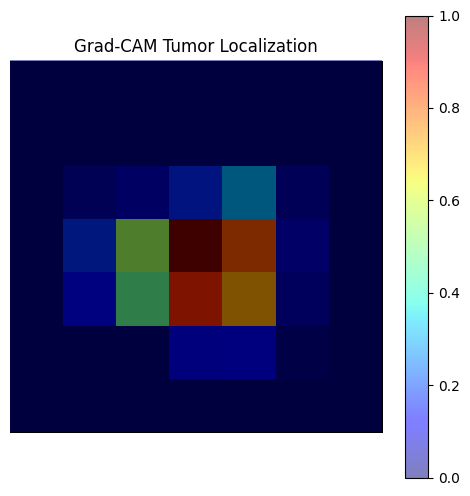

In [13]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.colorbar()
plt.title("Grad-CAM Tumor Localization")
plt.axis("off")
plt.show()


In [14]:
import cv2
import numpy as np

# Resize heatmap to original image size
heatmap_resized = cv2.resize(heatmap, (224, 224))

# Convert to color map
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap_resized),
    cv2.COLORMAP_JET
)

# Convert original image to array
img_array_display = np.uint8(img_array[0] * 255)

# Overlay
superimposed_img = cv2.addWeighted(
    img_array_display,
    0.6,
    heatmap_color,
    0.4,
    0
)


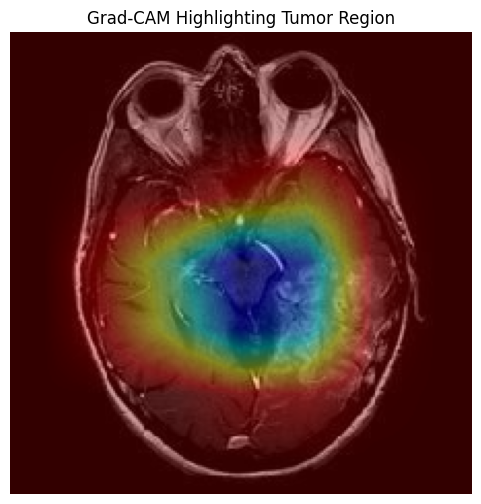

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(superimposed_img)
plt.title("Grad-CAM Highlighting Tumor Region")
plt.axis("off")
plt.show()


In [16]:
model_resnet.save("resnet50_brain_tumor_model.h5")


In [17]:
cv2.imwrite("gradcam_output.png", superimposed_img)


True

In [ ]:
loss, acc = model_resnet.evaluate(test_generator)
print("Test Accuracy:", acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3350 - loss: 1.3919
Test Accuracy: 0.3350253701210022


: 